# Onde paramos?

Vimos no último grupo de estudos, sobre como funciona uma árvore de decisão.

Uma árvore de decisão é capaz de se ajustar muito aos dados, se ela não for controlada, e com isso conseguimos atingir um viés extremamente baixo, mas ao passo que testamos esse modelo no conjunto de desenvolvimento, percebemos um problema na generalização deste modelo, ou seja, uma alta variância.


<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/08/eba93f5a75070f0fbb9d86bec8a009e9.png" width="400" height="400" />

<img src="https://cdn-images-1.medium.com/max/1024/0*SBQNWUA1dDtFsMHv.png" width="400" height="400" />



Quando podamos essa árvore para buscar a generalização, seja por poda manual, ou por poda otimizada (cost complexity pruning), reduzimos a variância, mas também aumentamos o viés.

<img src="https://www.researchgate.net/profile/Natarajan-Meghanathan/publication/275220711/figure/fig1/AS:354663229607936@1461569711255/A-Sample-Decision-Tree-Model-Figure-2-Decision-Stump-Model.png" width="400" height="400" />

## Começando com um dataset de exemplo

In [1]:
# import kaggle

# kaggle.api.authenticate()

In [3]:
# kaggle.api.dataset_download_files('adityakadiwal/water-potability', path='./', unzip=True)

In [101]:
import pandas as pd
import numpy as np

## Este dropna foi aplicado pra simplificar o caso de uso (dado que não estamos explorando o conjunto de dados)
## e não deve ser considerado sem análise numa situação do mundo real.

df = pd.read_csv('water_potability.csv').dropna()
df = df.reset_index(drop=True)

X = df.iloc[:, :-1]
y = df.iloc[:, -1:].values.flatten()

df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
1   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
2   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
3  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
4   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       18.436524       100.341674   4.628771           0  
1       11.558279        31.997993   4.075075           0  
2        8.399735        54.917862   2.559708           0  
3       13.789695        84.603556   2.672989           0  
4       12.363817        62.798309   4.401425           0

In [102]:
##Distribuicao de target

df.Potability.value_counts()

0    1200
1     811
Name: Potability, dtype: int64

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [105]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([240, 163]))

### Treinando uma Decision Tree (sem param tuning)

In [107]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(random_state=42)

dt = dt.fit(X_train, y_train)

In [117]:
from sklearn.metrics import roc_auc_score


y_pred_train_scores = dt.predict_proba(X_train)
y_pred_test_scores = dt.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 1.0
ROC AUC Score for TEST is 0.6319785276073621


#### Claramente temos um overfit e um problema sério de generalização

### Aplicando cost complexity pruning

In [121]:
ccp_path = dt.cost_complexity_pruning_path(X_train, y_train)
alphas = ccp_path['ccp_alphas']

In [127]:
alphas

array([0.        , 0.00054415, 0.0005597 , 0.00058043, 0.00058302,
       0.00058362, 0.00058916, 0.0005908 , 0.0005908 , 0.00059701,
       0.00059701, 0.00059701, 0.0006015 , 0.00060412, 0.00060672,
       0.00061016, 0.00062189, 0.00069296, 0.00072739, 0.00076777,
       0.00079062, 0.00082919, 0.00082919, 0.00082919, 0.00082919,
       0.00082919, 0.00082919, 0.00082919, 0.00082919, 0.00082919,
       0.00082919, 0.00082919, 0.00082919, 0.00082919, 0.00082919,
       0.00082919, 0.00082919, 0.00082919, 0.00083634, 0.00085078,
       0.00089984, 0.00092677, 0.00093284, 0.00093284, 0.00093284,
       0.00093284, 0.00093284, 0.00093284, 0.00093284, 0.00093284,
       0.00093284, 0.00094226, 0.00094764, 0.00094764, 0.00094764,
       0.000956  , 0.00096739, 0.00097726, 0.00099502, 0.00099502,
       0.00099502, 0.00099502, 0.00099502, 0.00099502, 0.00099502,
       0.00100498, 0.00102612, 0.00102826, 0.00102886, 0.00103648,
       0.00103648, 0.00103648, 0.00103648, 0.00103648, 0.00104

In [125]:
alphas.min()

0.0

In [126]:
alphas.max()

0.010769993752421917

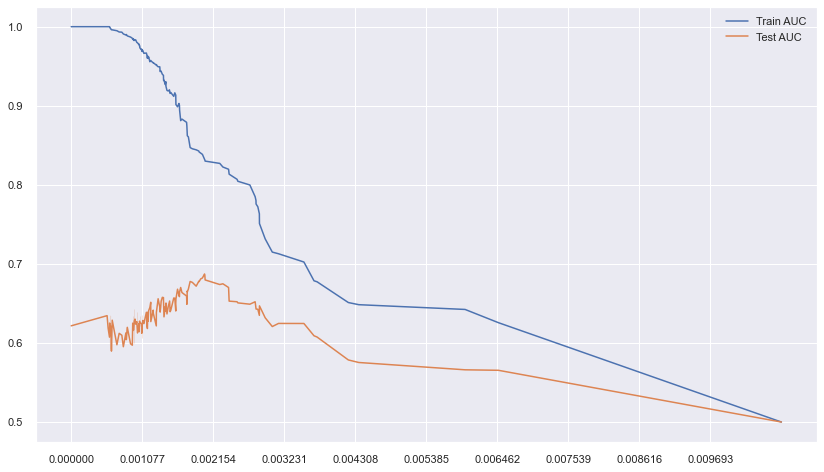

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

train_auc, test_auc = [],[]


for alpha in alphas:
    tree = DecisionTreeClassifier(ccp_alpha=alpha)
    
    tree.fit(X_train, y_train)
    y_train_pred_proba = tree.predict_proba(X_train)
    y_test_pred_proba = tree.predict_proba(X_test)
    
    train_auc.append(roc_auc_score(y_train, y_train_pred_proba[:,1]))
    test_auc.append(roc_auc_score(y_test, y_test_pred_proba[:,1]))
    

sns.set()
plt.figure(figsize=(14, 8))

sns.lineplot(y=train_auc, x=alphas, label="Train AUC");
sns.lineplot(y=test_auc, x=alphas, label="Test AUC");

    
plt.xticks(ticks=np.arange(0.00, alphas.max(), alphas.max()/10));


In [131]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(ccp_alpha=0.002, random_state=42)

dt = dt.fit(X_train, y_train)

In [132]:
from sklearn.metrics import roc_auc_score


y_pred_train_scores = dt.predict_proba(X_train)
y_pred_test_scores = dt.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.8384942451131687
ROC AUC Score for TEST is 0.6870015337423313


#### Feature importances

A importância de cada variável na construção de uma árvore nada mais é do que  o cálculo de decaímento em impureza por nó ponderada pela probabilidade de alcançar este nó.



A probabilidade de alcançar o nó pode ser calculada pelo número de amostras que alcançaram este node, dividido pelo número total de amostras.

$node\_probability = \frac{n\_samples\_inside\_node}{n\_total\_samples}$

Quanto maior o valor, mais importante é a feature

#### Mas como é essa árvore que criamos?

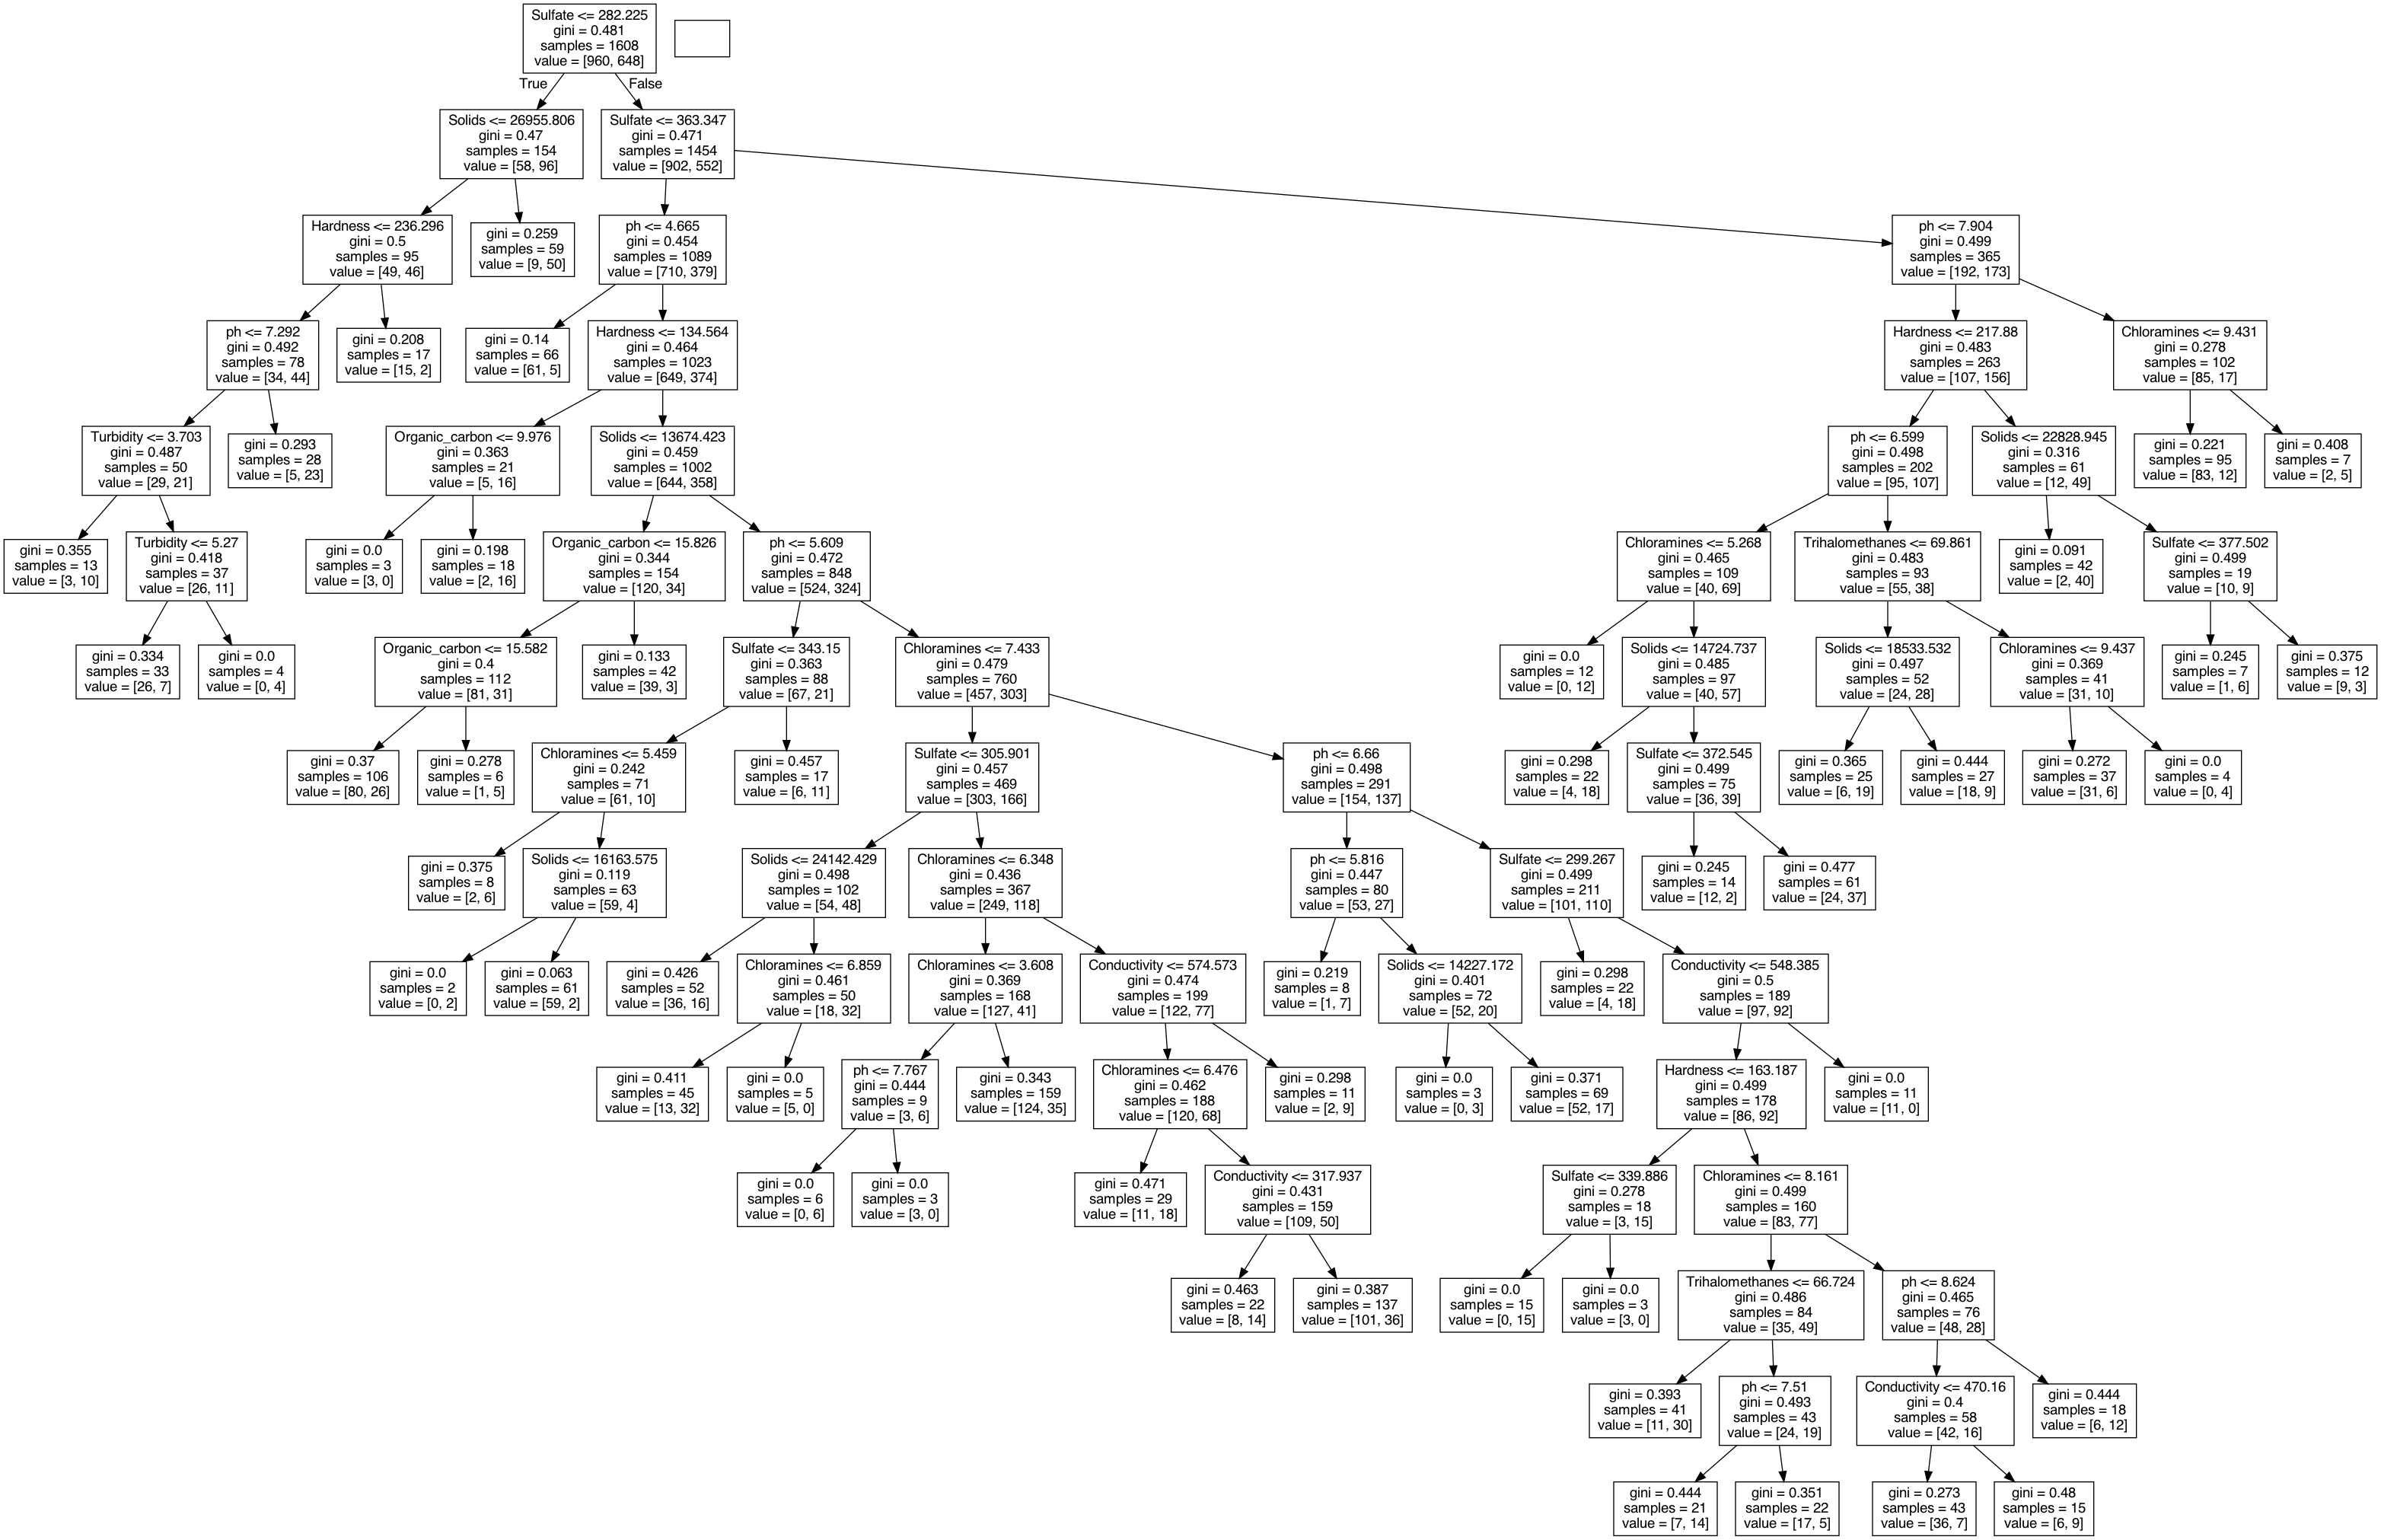

In [134]:
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data


dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# E como melhorar isso?

<img src="https://miro.medium.com/max/699/0*7aEFnmaxbKzwqUNc" width="400" height="400" />

# Métodos de ensemble


O objetivo geral de aplicarmos métodos de ensemble é unir um conjunto de algoritmos estimadores de tal forma que consigamos melhorar a **generalização** (reduzindo a variância) e/ou buscar uma **melhor performance** para o modelo (reduzindo o viés).

Como mencionado na explicação anterior sobre Viés-Variância, nem sempre é possível atingir os dois cenários de forma ótima, mas é o que buscamos a depender da situação.

Então, que raios é este ensemble?

## O que significa ensemble?


A etimologia da palavra deriva do francês e significa:

- Um grupo de coisas separadas que contribuem para um completo coordenado, organizado.


Para o nosso caso especial, em aprendizado de máquina, ensemble é todo combinado de algoritmos separados, que após unidos, nos dão um novo resultado. Mas tal como na culinária, é possível misturar os mesmos ingredientes de diversas formas para obter resultados distintos.

## Quais as formas possíveis de ensemble?

Vamos falar de alguns cenários possíveis e conhecidos, mas lembre-se que a habilidade de misturar algoritmos está sujeita a criatividade do cientista de dados e as premissas que ele deseja perseguir.


- **Bagging**
- **Pasting**
- **Boosting**

Além disso, é importante sabermos que existem os ensembles homogeneos e heterogeneos.*

#### Ensemble Homogeneo
- É quando o estimador base de todo o agrupamento é único.

#### Ensemble Heterogeneo
- Permite a criação de um ensemble de diversos algoritmos distintos, como por exemplo o **VotingClassifier** e o **StackingClassifier**


*Por questões de simplicidade, vamos nos manter apenas nos ensembles homogeneos neste artigo.


# Ensembles Paralelos

## Bagging (Bootstrap + Aggregation)

Você deve se lembrar em estatística que por vezes é muito custoso obtermos uma amostra que consiga representar a população, certo? Ainda mais quando olhamos para períodos prévios a toda esta onda de Big Data, em que obter uma noção de tudo que ocorre em um país do tamanho do nosso era bem difícil e você precisaria extrair suas conclusões com algumas amostras.


Uma solução ao ponto de aproximar a distribuição amostral da distribuição real (população), foi o uso do Bootstrap, onde você passa a extrair sub-amostras do seu conjunto amostral, sempre com reposição. Com isso, podemos chegar mais próximos de nossa distribuição real sem o custo necessário para obter novas amostras (a exemplo, fazer pesquisa de campo).

Ao ter estes subconjuntos, podemos treinar o nosso algoritmo de base em cada um dos subconjuntos, com um conjunto limitado de características, para obtermos vários modelos distintos com suas próprias opiniões.

Ao fim, é quase o que a RandomForest faz!


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/440px-Ensemble_Bagging.svg.png" />


#### [Bagging main ideas - Statquest](https://www.youtube.com/watch?v=Xz0x-8-cgaQ)

## Bagging Classifier

### BaggingClassifier padrão, n_estimators=10

In [164]:
%%time

from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(base_estimator=None, random_state=42)

bagging_clf = bagging_clf.fit(X_train, y_train)

CPU times: user 78 ms, sys: 5.83 ms, total: 83.8 ms
Wall time: 85.3 ms


In [165]:
%%time
from sklearn.metrics import roc_auc_score


y_pred_train_scores = bagging_clf.predict_proba(X_train)
y_pred_test_scores = bagging_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9990861304012346
ROC AUC Score for TEST is 0.6747060327198364
CPU times: user 12.3 ms, sys: 2.78 ms, total: 15.1 ms
Wall time: 14 ms


## Parametros principais

- n_estimators
- max_features
- max_samples

### Será que um colegiado de estimadores pode me auxiliar?

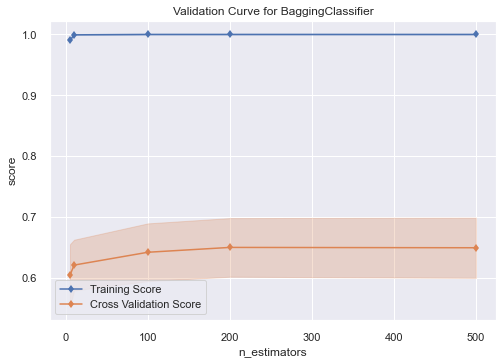

<AxesSubplot:title={'center':'Validation Curve for BaggingClassifier'}, xlabel='n_estimators', ylabel='score'>

In [166]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    BaggingClassifier(random_state=42), param_name="n_estimators",
    param_range=[5, 10, 100, 200, 500], cv=5, scoring="roc_auc"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

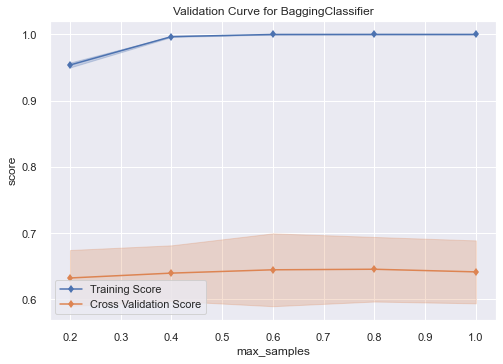

<AxesSubplot:title={'center':'Validation Curve for BaggingClassifier'}, xlabel='max_samples', ylabel='score'>

In [169]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    BaggingClassifier(n_estimators=100, random_state=42), param_name="max_samples",
    param_range=[0.2, 0.4, 0.6, 0.8, 1.0], cv=5, scoring="roc_auc"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

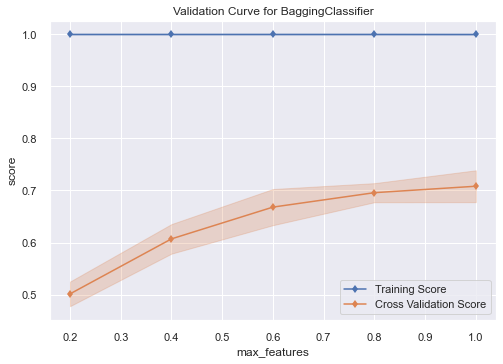

<AxesSubplot:title={'center':'Validation Curve for BaggingClassifier'}, xlabel='max_features', ylabel='score'>

In [484]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    BaggingClassifier(n_estimators=100, max_samples=0.6, random_state=42), param_name="max_features",
    param_range=[0.2, 0.4, 0.6, 0.8, 1.0], cv=5, scoring="roc_auc"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

In [171]:
%%time

bagging_clf = BaggingClassifier(n_estimators=100, max_samples=0.6, max_features=1.0, random_state=42)

bagging_clf = bagging_clf.fit(X_train, y_train)

y_pred_train_scores = bagging_clf.predict_proba(X_train)
y_pred_test_scores = bagging_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9998842592592593
ROC AUC Score for TEST is 0.6896600204498978
CPU times: user 452 ms, sys: 14.7 ms, total: 467 ms
Wall time: 473 ms


### Olhando por dentro dos estimadores do BaggingCLF

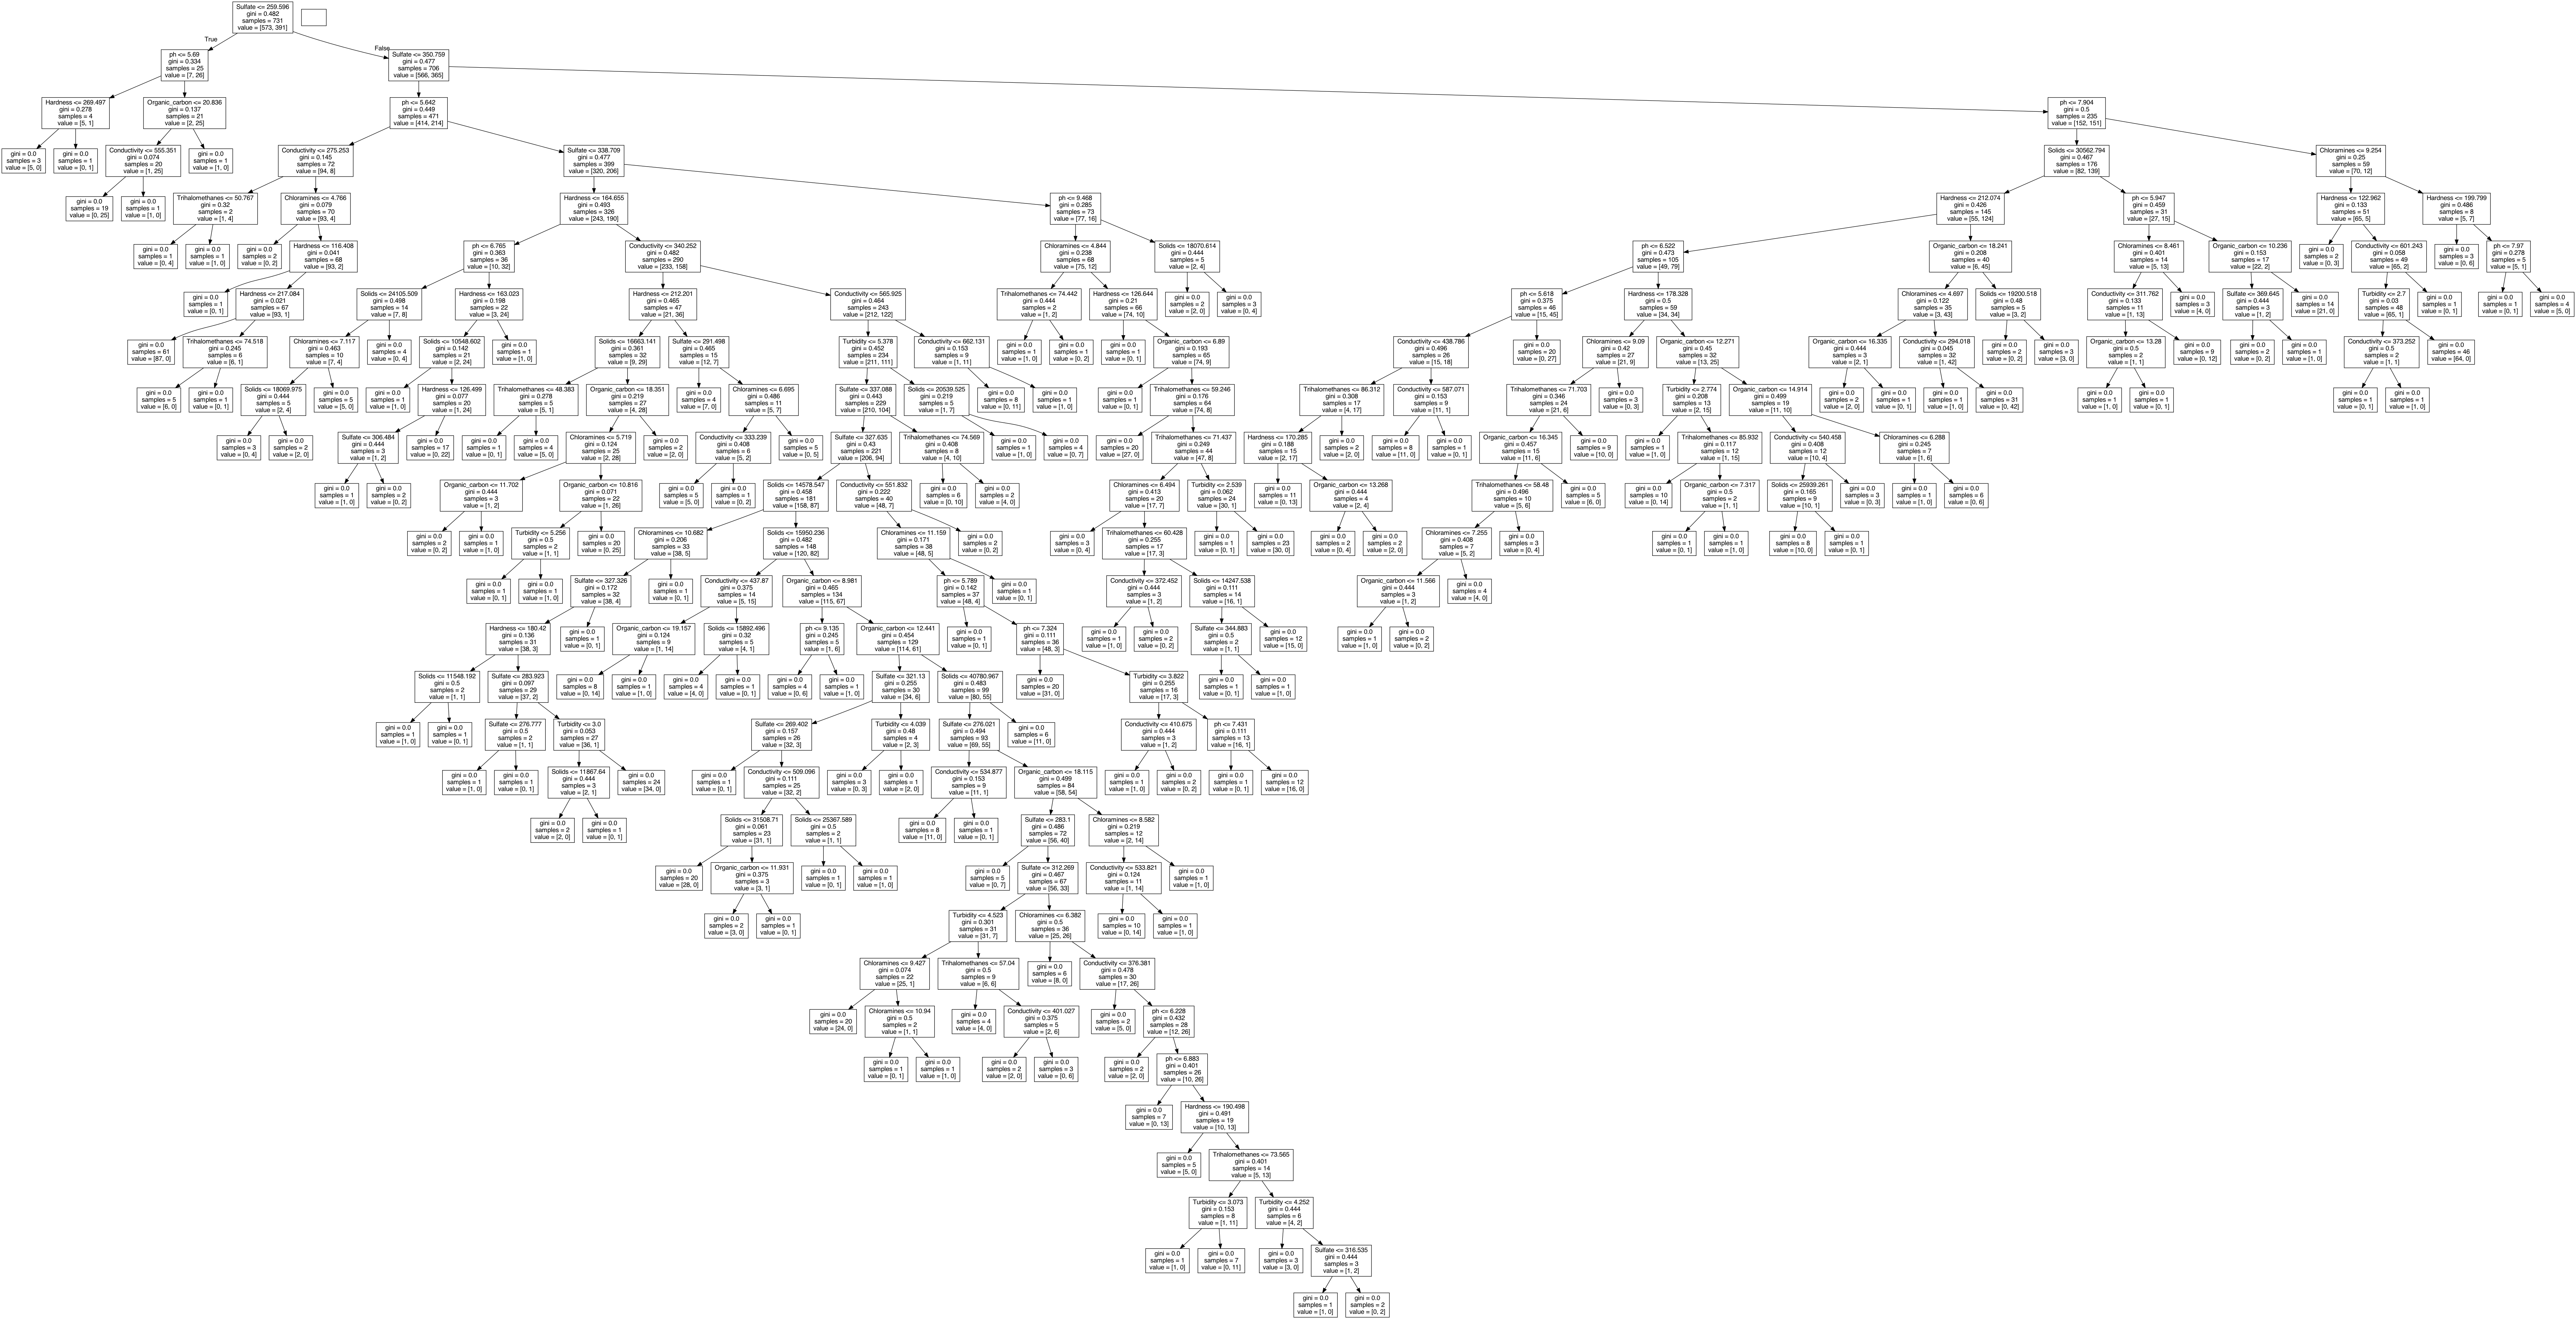

In [506]:
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data


idx = 2
dot_data = StringIO()
export_graphviz(bagging_clf.estimators_[idx], out_file=dot_data, feature_names=X_train.columns)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Random Forests

Diferente do Bagging que pode se adaptar com quaisquer estimadores, a Random Forest é inteiramente projetada para árvores de decisão, e com isso traz também seus parâmetros de otimização

## Random Forest Classifier, n_estimators=10

In [172]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)

rf_clf = rf_clf.fit(X_train, y_train)

y_pred_train_scores = rf_clf.predict_proba(X_train)
y_pred_test_scores = rf_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9990467463991769
ROC AUC Score for TEST is 0.613803680981595
CPU times: user 35.3 ms, sys: 19.4 ms, total: 54.7 ms
Wall time: 66.3 ms


## Que parametros otimizar?

Como o dataset é pequeno, trabalhar o conjunto de amostras pode não ser tão bacana, então vamos focar nos três abaixo:

- n_estimators
- max_depth
- max_features

### Trabalhando o tamanho de nossa árvore

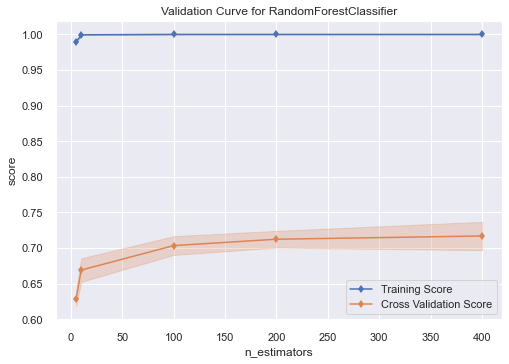

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [266]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    RandomForestClassifier(random_state=42), param_name="n_estimators",
    param_range=[5, 10, 100, 200, 400], cv=5, scoring="roc_auc"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

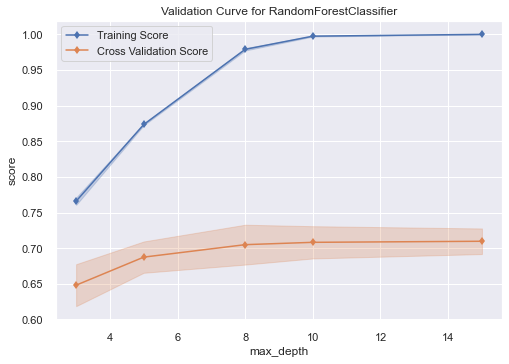

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [267]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    RandomForestClassifier(n_estimators=200, random_state=42), param_name="max_depth",
    param_range=[3, 5, 8, 10, 15], cv=5, scoring="roc_auc"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

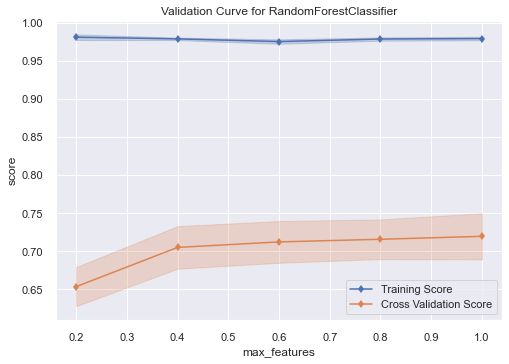

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_features', ylabel='score'>

In [269]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42), param_name="max_features",
    param_range=[0.2, 0.4, 0.6, 0.8, 1.0], cv=5, scoring="roc_auc"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

* Essa abordagem traz consigo um problema, ao trabalhar max_depth e max_features de forma independente, é possível que não consigamos extrair o melhor resultado, dado que ambos os hiperparâmetros tem relevância na construção da árvore.

* Uma melhor forma de lidar com isso seria com um algoritmo de otimização de parâmetros que fizesse diversos testes em conjunto, algo que deixaremos pra outro momento.

In [405]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=8, max_features=1.0, random_state=42)

rf_clf = rf_clf.fit(X_train, y_train)

y_pred_train_scores = rf_clf.predict_proba(X_train)
y_pred_test_scores = rf_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9628986625514403
ROC AUC Score for TEST is 0.6930214723926379
CPU times: user 919 ms, sys: 16.3 ms, total: 935 ms
Wall time: 969 ms


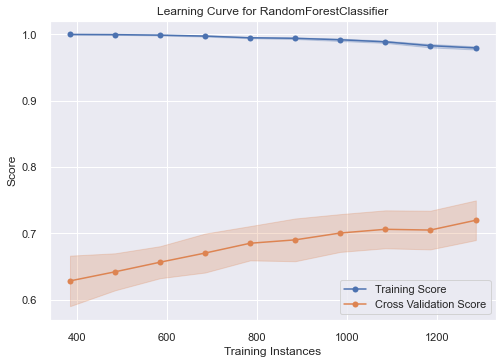

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [406]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

viz = LearningCurve(
    RandomForestClassifier(n_estimators=200, max_depth=8, max_features=1.0, random_state=42),
    cv=5, train_sizes=sizes,scoring="roc_auc", n_jobs=4
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

## E se buscassemos o pruning com o ccp_alpha ao invés de um pruning manual?

O problema em relação a uma árvore de decisão especial é que a RandomForest não nos traz a possibilidade de calcular o ccp_path e com isso mapear os possíveis alphas.

Então vamos pegar como exemplo a primeira árvore da RandomForest treinada e partir dela, aceitando o potencial de aleatoriedade que está inserido nela.

In [407]:
rf_clf.estimators_[0]

DecisionTreeClassifier(max_depth=8, max_features=1.0, random_state=1608637542)

In [408]:
ccp_path = rf_clf.estimators_[0].cost_complexity_pruning_path(X_train, y_train)
rf_alphas = ccp_path['ccp_alphas']

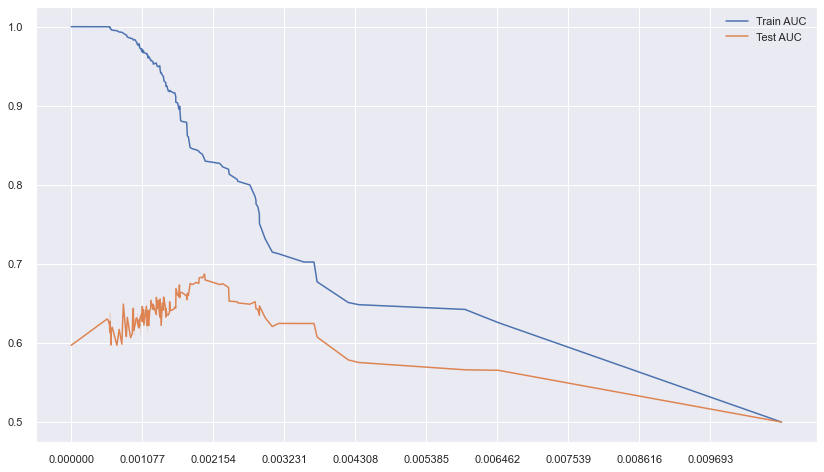

In [409]:
import seaborn as sns
import matplotlib.pyplot as plt

train_auc, test_auc = [],[]


for alpha in alphas:
    tree = DecisionTreeClassifier(ccp_alpha=alpha)
    
    tree.fit(X_train, y_train)
    y_train_pred_proba = tree.predict_proba(X_train)
    y_test_pred_proba = tree.predict_proba(X_test)
    
    train_auc.append(roc_auc_score(y_train, y_train_pred_proba[:,1]))
    test_auc.append(roc_auc_score(y_test, y_test_pred_proba[:,1]))
    

sns.set()
plt.figure(figsize=(14, 8))

sns.lineplot(y=train_auc, x=alphas, label="Train AUC");
sns.lineplot(y=test_auc, x=alphas, label="Test AUC");

    
plt.xticks(ticks=np.arange(0.00, alphas.max(), alphas.max()/10));

In [410]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf_ccp = RandomForestClassifier(n_estimators=200, ccp_alpha=0.002, random_state=42)

rf_clf_ccp = rf_clf_ccp.fit(X_train, y_train)

y_pred_train_scores = rf_clf_ccp.predict_proba(X_train)
y_pred_test_scores = rf_clf_ccp.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9905574845679012
ROC AUC Score for TEST is 0.6811349693251535
CPU times: user 837 ms, sys: 7.8 ms, total: 845 ms
Wall time: 653 ms


### Portanto, o pruning manual parece ter feito mais sentido

## Também é possível olhar cada árvore da floresta

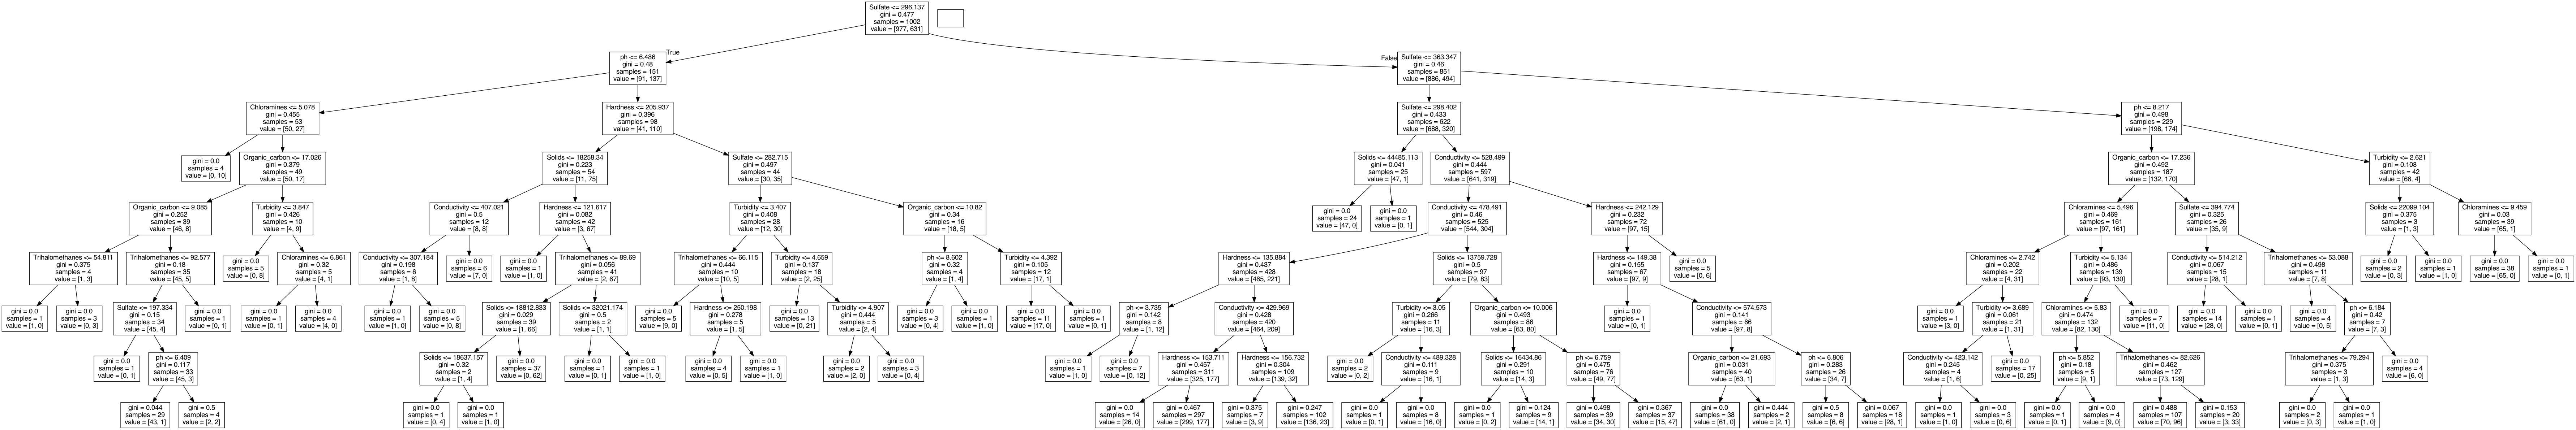

In [490]:
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data


idx = np.random.randint(0, 200, 1)[0]
dot_data = StringIO()
export_graphviz(rf_clf.estimators_[idx], out_file=dot_data, feature_names=X.columns)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Destas 200 árvores, devem ter inúmeras de má qualidade, e se eu selecionar somente as mais robustas?

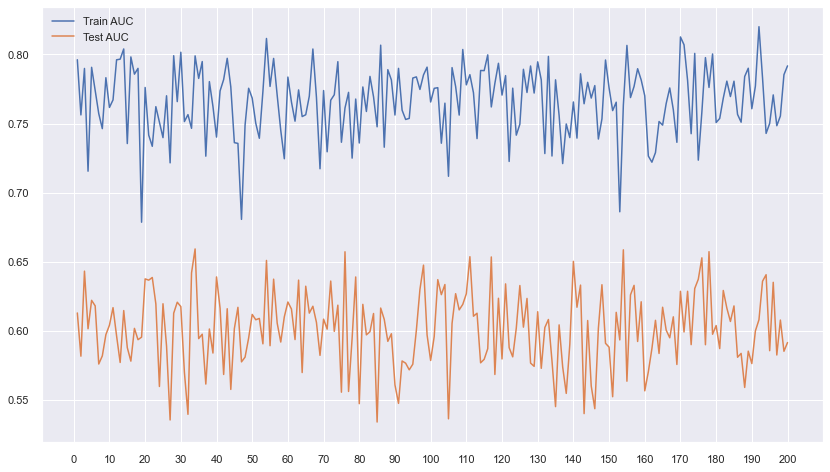

In [412]:
train_auc, test_auc = [],[]


variance_list = []

for i, estimator in enumerate(rf_clf.estimators_):
    y_train_pred_proba = estimator.predict_proba(X_train.to_numpy())
    y_test_pred_proba = estimator.predict_proba(X_test.to_numpy())
    
    train_auc_metric = roc_auc_score(y_train, y_train_pred_proba[:,1])
    test_auc_metric = roc_auc_score(y_test, y_test_pred_proba[:,1])
    
    variance_list.append(train_auc_metric-test_auc_metric)
    train_auc.append(train_auc_metric)
    test_auc.append(test_auc_metric)
    
variance_df = pd.DataFrame({"estimator_idx": np.linspace(1, 200, 200),
                            "variance": variance_list,
                            "train_auc": train_auc,
                            "test_auc": test_auc})
    
sns.set()
plt.figure(figsize=(14, 8))

sns.lineplot(y=train_auc, x=np.linspace(1, 200, 200), label="Train AUC");
sns.lineplot(y=test_auc, x=np.linspace(1, 200, 200), label="Test AUC");

    
plt.xticks(ticks=np.arange(0, 210, 10));

In [413]:
variance_df.sort_values(["train_auc", "test_auc", "variance"], ascending=[False, False, True])[0:20]

estimator_idx  variance  train_auc  test_auc
191          192.0  0.212015   0.820105  0.608090
169          170.0  0.184012   0.812680  0.628668
53            54.0  0.160586   0.811583  0.650997
170          171.0  0.207785   0.807030  0.599246
85            86.0  0.190184   0.806735  0.616552
154          155.0  0.242932   0.806557  0.563625
13            14.0  0.189264   0.803988  0.614724
66            67.0  0.186102   0.803958  0.617855
108          109.0  0.184423   0.803608  0.619185
29            30.0  0.184014   0.801627  0.617612
173          174.0  0.170102   0.800790  0.630688
178          179.0  0.202773   0.800358  0.597584
115          116.0  0.212549   0.799716  0.587168
27            28.0  0.186287   0.799107  0.612820
33            34.0  0.139686   0.798990  0.659305
132          133.0  0.190326   0.798596  0.608269
15            16.0  0.220075   0.798219  0.578144
176          177.0  0.207718   0.797736  0.590018
42            43.0  0.181178   0.797231  0.616053
55            56.0  0.159698   0.797147  0.637449

In [414]:
list_idx_estimators = variance_df.sort_values(["train_auc", "test_auc", "variance"], ascending=[False, False, True])[0:20]['estimator_idx'].astype(int).to_list()

## Recomposed Forest com os top 20 estimadores

In [347]:
selected_estimators = list(map(rf_clf.estimators_.__getitem__, list_idx_estimators))

In [348]:
train_predicted_proba_results = []
test_predict_proba_results = []

for estimator in selected_estimators:
        y_train_pred_proba = estimator.predict_proba(X_train.to_numpy())
        y_test_pred_proba = estimator.predict_proba(X_test.to_numpy())
        
        train_predicted_proba_results.append(y_train_pred_proba)
        test_predict_proba_results.append(y_test_pred_proba)

In [349]:
train_final_proba = np.array(train_predicted_proba_results).mean(axis=0)
test_final_proba = np.array(test_predict_proba_results).mean(axis=0)

In [350]:
roc_auc_train_result = roc_auc_score(y_train, train_final_proba[:,1])
roc_auc_test_result = roc_auc_score(y_test, test_final_proba[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9343131108539094
ROC AUC Score for TEST is 0.6927914110429447


## Vale a pena este processo "artesanal"? 

O objetivo aqui é mostrar que podemos editar plenamente a nossa árvore, e ao final de todo este processo mantivemos a performance no conjunto de teste, reduzindo a complexidade de nossa árvore, e regularizando o conjunto de treino para reduzir overfitting.

Como comparativo de sanidade, veja abaixo como seria a árvore com os mesmos parametros, só que com apenas 20 estimadores.

In [352]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf_20 = RandomForestClassifier(n_estimators=20, max_depth=8, max_features=1.0, random_state=42)

rf_clf_20 = rf_clf_20.fit(X_train, y_train)

y_pred_train_scores = rf_clf_20.predict_proba(X_train)
y_pred_test_scores = rf_clf_20.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9415895061728394
ROC AUC Score for TEST is 0.6893916155419222
CPU times: user 100 ms, sys: 12.3 ms, total: 112 ms
Wall time: 117 ms


Um resultado bem semelhante né? A decisão sobre a validade daqueles 0.003 pontos que perdemos no conjunto de teste é subjetiva, cada novo acerto corresponde a mais 50 mil reais na conta? Se sim, então cada pequeno ponto acima é um sucesso e deve ser buscado.

Este dataset representa a predição de potabilidade de água, se no caso de um erro a mais, custasse uma vida, por exemplo, certamente seguiria o modelo de estilo **"mosaico"** gerado alguns passos acima.

#### E o parâmetro de Out of Bagging Score?

Quando o bagging é realizado, existem amostras que ficam de fora pra cada um dos estimadores.

Suponha que para 23 das 100 árvores fitadas, as amostras 3, 15, 248 e 547 ficaram de fora, e com isso o out of bagging score poderá ser calculado em cima dessas amostras.

O processo se repete para todas as árvores em amostras distintas (de acordo com seus subsets) e um score final é gerado com a média dos scores.


Isso permite:

- Uma validação já em tempo de treinamento, o que é legal e prático.
- Uma noção de como está a generalização do modelo.

Por outro lado, é ruim devido ao processo acima, perceba que alguns estimadores consideram as amostras como um conjunto de validação, e outros não.

Pode ser útil quando separar um conjunto de validação não é possível (gerar mais dados ser caro demais, ou os dados são extremamente raros e só temos este conjunto), mas para todos os cenários busque dar preferência a guardar
um conjunto de validação apartado (com *train_test_split* por exemplo)

In [234]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: #ffff99' if is_max.any() else '' for v in is_max]

df.head(10).style.apply(highlight_greaterthan, threshold=240, column='Hardness', axis=1)

# Pasting

Semelhante ao processo de bagging, o pasting também executa a mesma agregação, porém o faz de forma que para cada amostragem, o processo é feito sem reposição.

#### Bootstrap = True

In [235]:
%%time


bagging = BaggingClassifier(base_estimator=None, n_estimators=10, bootstrap=True, random_state=42)

bagging = bagging.fit(X_train, y_train)

y_pred_train_scores = bagging.predict_proba(X_train)
y_pred_test_scores = bagging.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9990861304012346
ROC AUC Score for TEST is 0.6747060327198364
CPU times: user 71.7 ms, sys: 10.8 ms, total: 82.5 ms
Wall time: 96.6 ms


In [237]:
len(np.unique(bagging.estimators_samples_[0]))

1022

#### Bootstrap = False

In [243]:
%%time


pasting = BaggingClassifier(base_estimator=None, n_estimators=10, bootstrap=False, random_state=42)

pasting = pasting.fit(X_train, y_train)

y_pred_train_scores = pasting.predict_proba(X_train)
y_pred_test_scores = pasting.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 1.0
ROC AUC Score for TEST is 0.6359790388548058
CPU times: user 120 ms, sys: 10.5 ms, total: 131 ms
Wall time: 135 ms


In [244]:
len(np.unique(pasting.estimators_samples_[0]))

1608

Para saber mais sobre Pasting

[B1999](https://link.springer.com/article/10.1023/A:1007563306331) - 
L. Breiman, “Pasting small votes for classification in large databases and on-line”, Machine Learning, 36(1), 85-103, 1999.

# Ensembles sequenciais

## Boosting

É um técnica de ensemble que aprende com os erros do estimador base anterior para realizar novas predições no futuro.

Esta é uma técnica sequencial, diferente do bagging que é realizada de forma paralela, no qual combina diversos estimadores conhecidos como "fracos"para formar um estimador mais forte, aumentando a qualidade das predições do modelo.

A técnica de boosting é utilizada em diversos algoritmos, entre eles: Adaptive Boosting (AdaBoost), Gradient Boosting, Extreme Gradient Boosting (XGB), dentre outros.


### Como funciona?

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20210707140911/Boosting.png" />

## AdaBoost


O paper original foi escrito por [Yoav Freund e Robert Schapire](https://reader.elsevier.com/reader/sd/pii/S002200009791504X?token=22F5A749457DACF9C9244FAB78383333C0463E3999BE062A259B831BBECFF35CC80530E92F6473C853D49EA66E09E213&originRegion=us-east-1&originCreation=20220417180023) e segue a idéia de que um classificador "fraco" pode não ser tão bom em fazer uma predição, mas uma sequência de classificadores fracos distintos, que aprendem com os erros dos classificadores anteriores, podem compor um classificador forte.

O modelo segue a seguinte idéia:

<img src="https://miro.medium.com/max/766/0*a8A0DzfBHgtawNiq.png" />

Onde:

- **alpha** é o peso assinalado para o modelo
- **h(x)** é o estimador base utilizado no modelo.
- **T** é o número de estimadores base utilizados. O número ideal a ser usado depende do conjunto de dados.

Portanto, o objetivo é encontrar a soma ponderada dos classificadores que mais representam o a nossa função H(x).

### Passo a passo

**Passo 1**: Inicialmente, todas as amostras possuem pesos iguais que obedecem a 1/n, ou seja, n sendo o número de amostras.

**Passo 2**: Cria-se uma decision stump nova, selecionando qual a melhor feature para dividir o conjunto com base em um algoritmo de busca greedy, e também encontrando o melhor threshold para o split.

**Passo 3**: Calcula-se o peso de todo o modelo. Em outras palavras, encontra-se o alpha. Experimentalmente, foi encontrado que com o aumento da taxa de erro, o peso diminui, conforme o gráfico.

<img src="https://miro.medium.com/max/1400/1*QpKRdPUkZAJpYKmUMK6HUQ.png" width=400 height=400 />

Encontramos o peso(alpha) usando a fórmula abaixo

<img src="https://miro.medium.com/max/1400/0*1iRCpqI3UNZFbSbO.png" >

**Passo 4**: Agora deve-se alterar o peso de todos os dados, aplicando mais importância as amostras que foram classificadas incorretamente e aumentando seus pesos, isso é feito pra penalizar os erros mais do que as predições corretas. Por outro lado, menos importância é dada aquilo que o modelo já aprendeu corretamente. Vide fórmula:

<img src="https://miro.medium.com/max/1400/0*gzzMcIZmvRSqED4c.png" >

O sinal positivo é para amostras classificadas incorretamente, e o sinal negativo é para as classificadas corretamente. Onde Wi é o peso atualizado, e W(i-1) é o peso anterior.

**Passo 5**: Nós normalizamos os pesos atualizados para que os pesos estejam dentro de 0 e 1, e sua soma seja 1 conforme a fórmula:

w(new) = w(i)/soma de todos os pesos

**Passo 6**: Este processo se repete iterativamente para cada estimador, o número de iterações depende da parametrização de início.

### Vamos aplicar ao nosso conjunto de dados

In [435]:
from sklearn.ensemble import AdaBoostClassifier

adb_clf = AdaBoostClassifier(random_state=42)

In [436]:
%%time

adb_clf = adb_clf.fit(X_train, y_train)

y_pred_train_scores = adb_clf.predict_proba(X_train)
y_pred_test_scores = adb_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.7169712898662552
ROC AUC Score for TEST is 0.5574769938650307
CPU times: user 96.9 ms, sys: 1.92 ms, total: 98.8 ms
Wall time: 97.6 ms


### Principais parametros

Por padrão, o adaboost não nos dá muitas opções de exploração, tendo estas três possibilidades:

- Explorar o número de estimadores
- Explorar parâmetros do weak classifier
- Explorar a Learning Rate

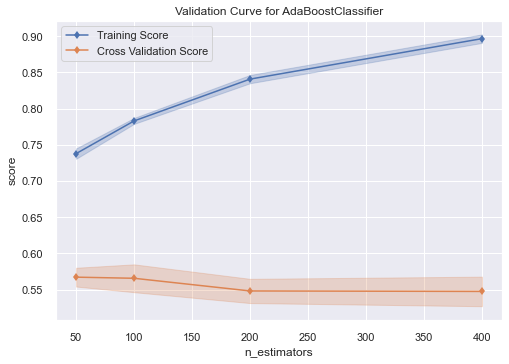

<AxesSubplot:title={'center':'Validation Curve for AdaBoostClassifier'}, xlabel='n_estimators', ylabel='score'>

In [455]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    AdaBoostClassifier(random_state=42), param_name="n_estimators",
    param_range=[50, 100, 200, 400], cv=5, scoring="roc_auc"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

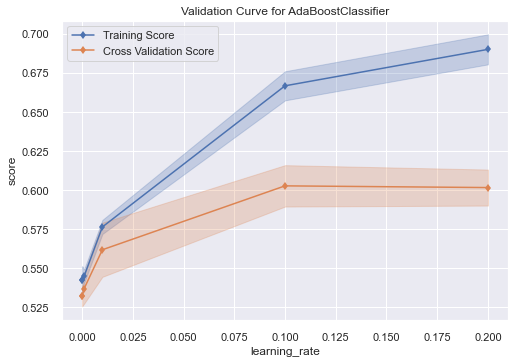

<AxesSubplot:title={'center':'Validation Curve for AdaBoostClassifier'}, xlabel='learning_rate', ylabel='score'>

In [460]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    AdaBoostClassifier(n_estimators=50, random_state=42), param_name="learning_rate",
    param_range=[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2], cv=5, scoring="roc_auc"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

In [510]:
%%time

adb_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), n_estimators=100, learning_rate=0.1, random_state=42)

adb_clf = adb_clf.fit(X_train, y_train)

y_pred_train_scores = adb_clf.predict_proba(X_train)
y_pred_test_scores = adb_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 1.0
ROC AUC Score for TEST is 0.6463701431492843
CPU times: user 1.17 s, sys: 26 ms, total: 1.19 s
Wall time: 1.23 s


### Como são as árvores dentro do AdaBoost?

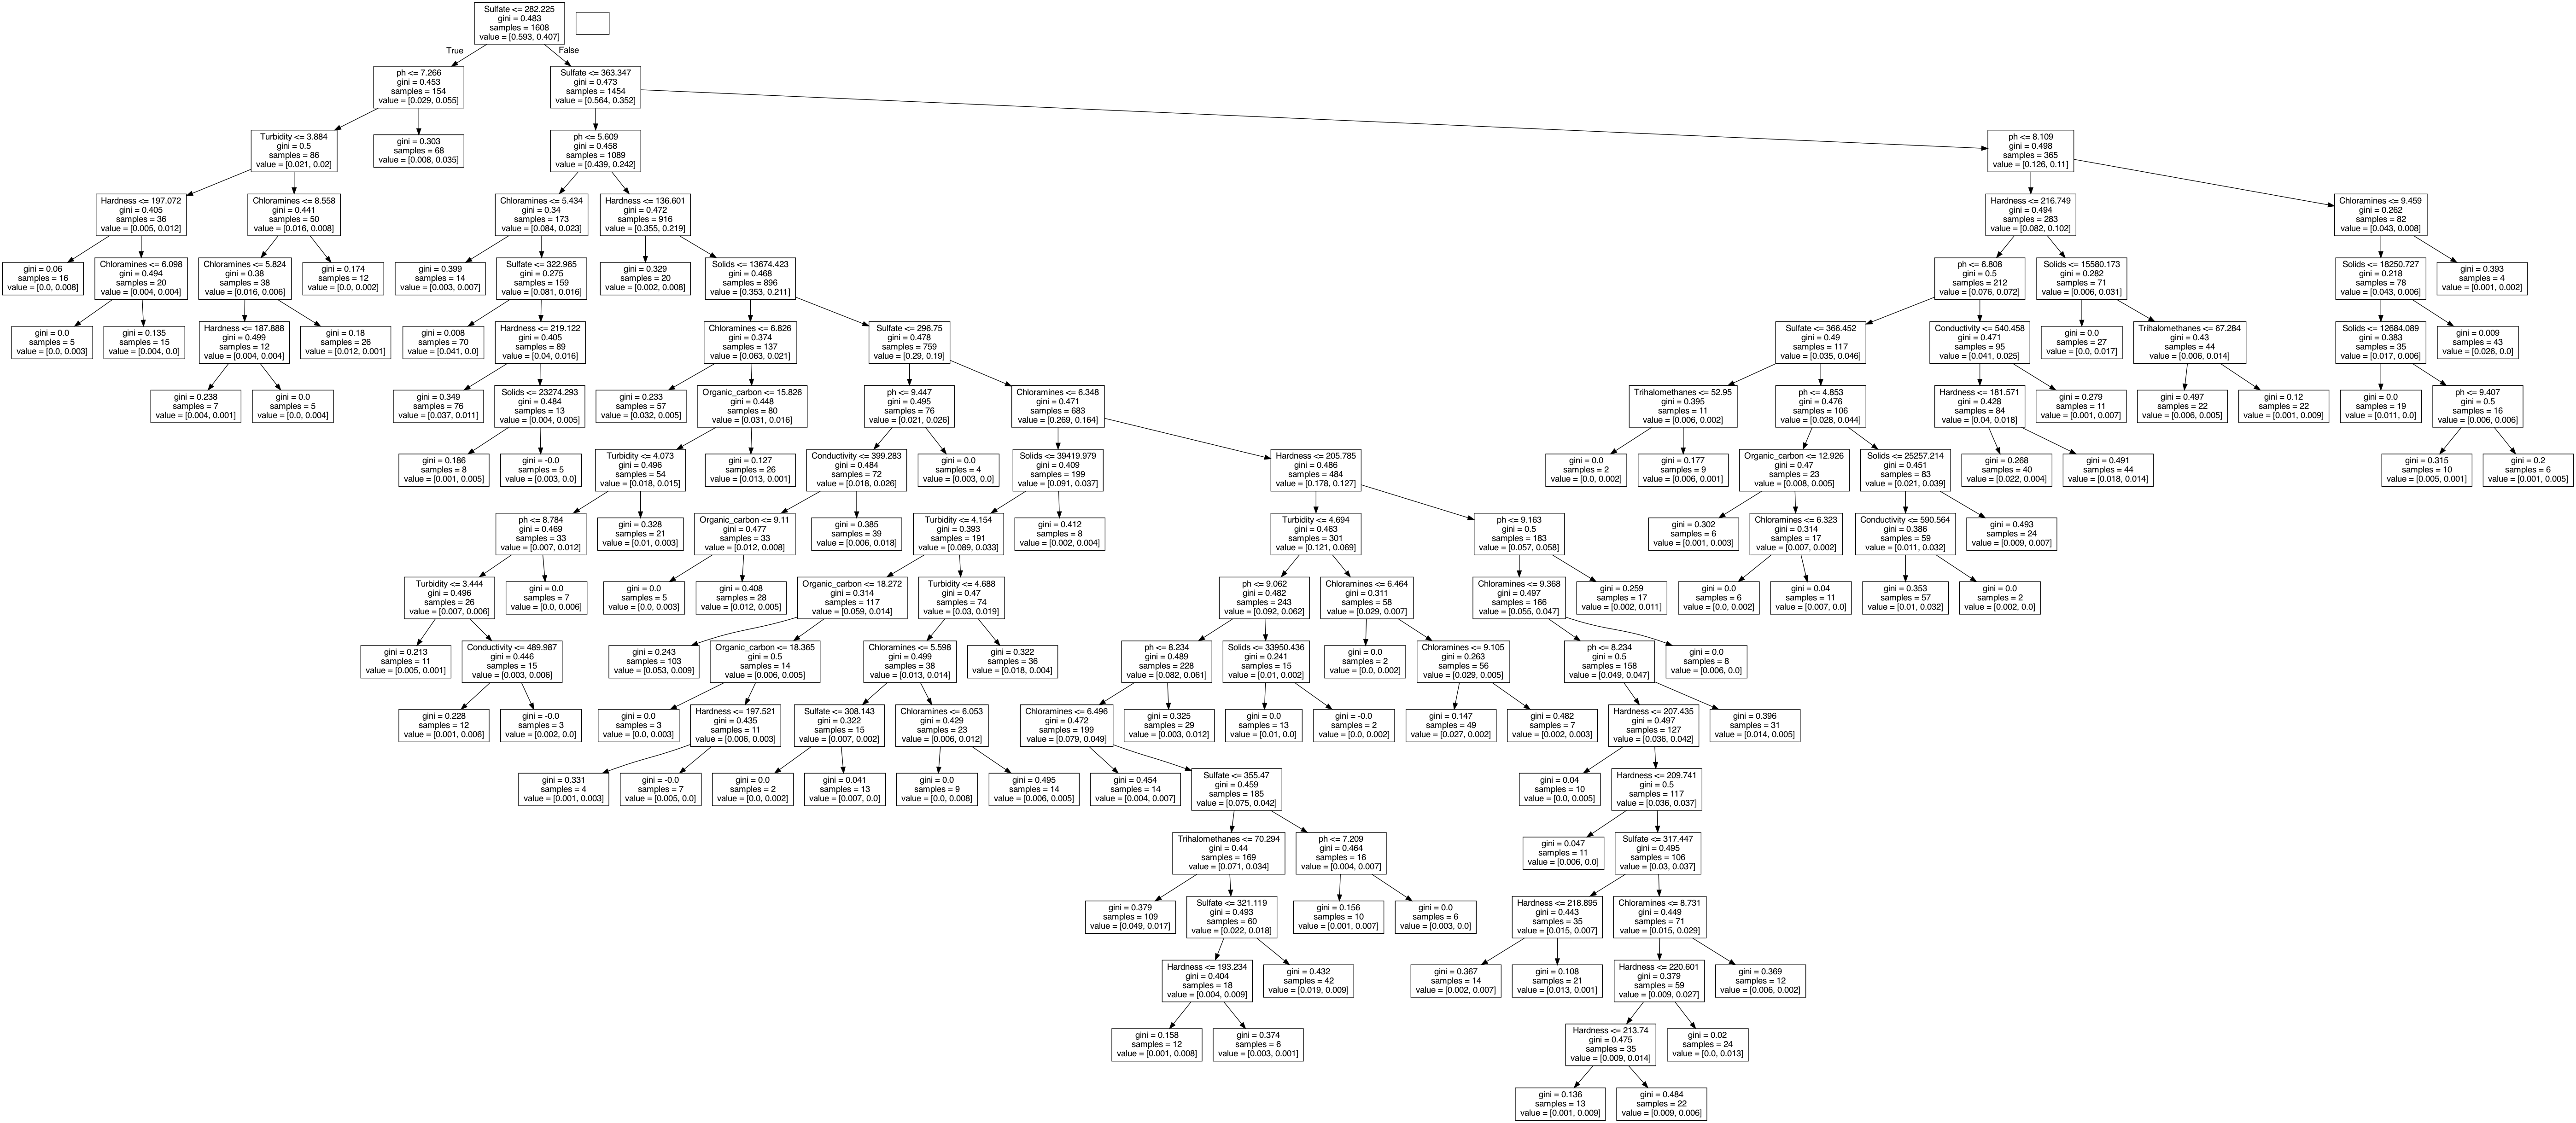

In [511]:
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data


idx = 3
dot_data = StringIO()
export_graphviz(adb_clf.estimators_[idx], out_file=dot_data, feature_names=X.columns)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Gradient Boosting

O algoritmo de Gradient Boosting é bem parecido com o AdaBoost, com algumas alterações.

Diferente do uso de Stumps, o Gradient Boosting costuma utilizar de 8 a 32 folhas ao invés de apenas 2 folhas como no AdaBoost.

Embora o AdaBoost dê pesos distintos a cada uma das árvores por intermédio do **alpha**, o Gradient Boosting pondera cada uma de suas árvores pelo mesmo peso, realizando alterações apenas nos pesos dos datasets.


### Passo a passo

<img src="https://miro.medium.com/max/1400/1*dWlneZmWitSdsk9Gj7MsyA.png" width=300 height=300 />

**Passo 1**: Calcular a média da variável resposta no caso de uma regressão, ou uma probabilidade inicial no caso de problemas de classificação.

<img src="https://miro.medium.com/max/1400/1*Dw5-E1r15db4aVN7Hf6bfA.png" width=400 height=400 />

**Passo 2**: Calcular os resíduos. Para cada amostra, calculamos os resíduos com a seguinte fórmula:
- residual = actual_value - predicted_value

O predicted_value neste caso é o que foi definido no passo 1

<img src="https://miro.medium.com/max/1400/1*EuYMrGN2r9jo6VlVBigX3A.png" width=400 height=400 />


**Passo 3**: Construa uma árvore de decisão, onde a variável resposta será os resíduos e não a target original.

<img src="https://miro.medium.com/max/1400/1*gjWwWylZuGNi6NgwhZO2fg.png" width=400 height=400 />

A saída de cada folha obedece a equação para os casos de regressão, e no cenário de classificação é ligeiramente diferente.

$\Large\gamma = \frac{\sum(residuals)}{n}$ (Regression task)

$\Large\gamma = \frac{\sum(residuals)}{\sum([Previous probability * (1-Previous probability)]}$ (Classification task)

Então, conforme mencionamos, após somar temos a árvore como:

<img src="https://miro.medium.com/max/1400/1*2qzgrmK8GM7q28Qm4SdGOw.png" width=400 height=400 />


**Passo 4**: Realize a predição do dataset usando todas as árvores já criadas do ensemble. Cada amostra passa pelas árvores de decisão do ensemble até chegar em seu resultado final.

<img src="https://miro.medium.com/max/1400/1*heTIEVLlsGhOjSoNOMXhsA.png" width=400 height=400 />
<img src="https://miro.medium.com/max/1400/1*l18XAxwRY1Enmjx3SJ-VAQ.png" width=400 height=400 />


**Passo 5**: Calcule os novos resíduos, conforme já fizemos no passo 2

<img src="https://miro.medium.com/max/1400/1*R3EOAzrqIQ2iuAF7E80f9A.png" width=400 height=400 />
<img src="https://miro.medium.com/max/1400/1*z0EV8Cm59XZVU2XfOjYFqQ.png" width=400 height=400 />

**Passo 6**: Repita os passos de 3 a 5 até atingir o número de iterações definidos no hiperparâmetro (por exemplo n_estimators)

**Passo 7**: Ao final, utilize o modelo completo para realizar a predição no test_set, por exemplo.

<img src="https://miro.medium.com/max/1400/1*c-Zo4QrliCyhio0iTp7z8g.png" />


[Para saber mais](https://www.youtube.com/watch?v=3CC4N4z3GJc&t=3s)

In [501]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42)

In [502]:
%%time

gb_clf = gb_clf.fit(X_train, y_train)

y_pred_train_scores = gb_clf.predict_proba(X_train)
y_pred_test_scores = gb_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9062379436728396
ROC AUC Score for TEST is 0.6310071574642127
CPU times: user 293 ms, sys: 17.6 ms, total: 311 ms
Wall time: 344 ms


## Parameter tuning

No geral, podemos olhar pros parâmetros dos modelos de Boosting sob duas categorias:

- **Tree-Specific Parameters**: Afetam cada árvore individualmente no modelo
- **Boosting Parameters**: Afetam a operação de Boosting do modelo.

Além de outros de funcionamento geral.


#### Tree Specific parameters

- **min_samples_split** - Define o número mínimo de amostras que são necessárias em um node para considerar um split. É usado pra controlar overfitting. Maiores valores previnem um modelo de aprender relações extremamente específicas de uma ou poucas amostras. Valores muito altos podem levar ao under-fitting. Deve ser tunado com CV.

- **min_samples_leaf** - Define o número mínimo de amostras necessárias em uma folha. Também é usado de forma semelhante ao min_samples_split para controlar overfitting. Geralmente menores valores devem ser escolhidos pra problemas desbalanceados para conseguir lidar com a especificidade do problema.

- **min_weight_fraction_leaf** - Semelhante ao anterior, mas é definido como uma fração do número total de observações ao invés de um valor inteiro definido. Use um (min_samples_leaf) ou o outro (min_weight_fraction_leaf).


- **max_depth** - A profundidade máxima da árvore, como já vimos. Pode ser usado para controlar o overfitting, tal como árvores muito profundas podem se ajustar demais aos dados de treinamento. Tune com CV.


- **max_leaf_nodes** - O número máximo de folhas que podem existir na árvore. Pode ser utilizado no lugar de max_depth. Dado que árvores binárias são criadas, uma profundidade "N" iria produzir um máximo de 2ˆn folhas. Se for setado, o GBM vai descartar o max_depth.

- **max_features** - O número de features considerado quando buscando pelo melhor split, sendo estas selecionadas de forma aleatória. De modo geral, a raíz quadrada do número total de features funciona bem, mas podemos buscar algo em torno de 30 a 40% do número total de features. Números muito altos podem levar ao overfitting, mas depende de cada caso.


#### Boosting parameters

- **learning_rate** - Determina o impacto de cada árvore no resultado final, controla a magnitude das mudanças ao passo que cada árvore é criada. Menores valores são geralmente preferidos, dado que fazem o modelo mais robusto a características específicas da árvore e permite generalizar bem.

Menores valores também requerem um número maior de árvores, e acabará sendo mais caro computacionalmente.

- **n_estimators** - Determina o número de árvores a ser criado. Apesar do GBM ser bem robusto em um número grande de árvores, ainda pode overfitar depois de certo ponto. Deve ser tunado utilizando CV para uma learning rate específica.

- **subsample** - A fração de amostras a ser selecionada por cada árvore, onde a seleção é feita de forma aleatória. Valores ligeiramente abaixo de 1 tornam o modelo mais robusto ao reduzir a variância. Tipicamente valores em torno de 0.8 funcionam bem, mas podem ser otimizados também com fine-tuning.

In [481]:
%%time

gb_clf = GradientBoostingClassifier(learning_rate=0.01,
                                    subsample=0.8,
                                    max_depth=7,
                                    random_state=42)

gb_clf = gb_clf.fit(X_train, y_train)

y_pred_train_scores = gb_clf.predict_proba(X_train)
y_pred_test_scores = gb_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9665075231481481
ROC AUC Score for TEST is 0.6983384458077709
CPU times: user 535 ms, sys: 12.9 ms, total: 548 ms
Wall time: 574 ms


In [523]:
y_pred_train_scores = gb_clf.predict_proba(X_train)
y_pred_test_scores = gb_clf.predict_proba(X_test)

roc_auc_train_result = roc_auc_score(y_train, y_pred_train_scores[:,1])
roc_auc_test_result = roc_auc_score(y_test, y_pred_test_scores[:,1])


print(f"ROC AUC Score for TRAIN is {roc_auc_train_result}")
print(f"ROC AUC Score for TEST is {roc_auc_test_result}")

ROC AUC Score for TRAIN is 0.9248665766460905
ROC AUC Score for TEST is 0.6947724948875256


[P/ detalhar mais em Feature Importances](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

## XGBoost/CatBoost


Por questões de tempo, deixarei alguns links pra aprofundar nestes temas:


- [XGBoost - Tianqi Chen (coautor with Carlos Guestrin)](https://www.youtube.com/watch?v=8Y-droPeKu8)
- [Catboost - Anna Veronika Dorogush - Head of Yandex](https://www.youtube.com/watch?v=8o0e-r0B5xQ)

### XGBoost

- Constrói camada a camada, e depois efetua o pruning
- Não consegue lidar com categóricas
- É lento em comparação ao XGBoost
- Não consegue lidar com problemas de imagens
- Não era capaz de lidar com missing values


### Catboost
- Constrói árvores simétricas, menos propenso ao overfitting
- Permite predições muito mais rápidas, chega a 
20x em relação ao XGBoost
- Lida com variáveis categóricas por intermédio de um processo de encoding, trabalhando com as estatísticas das categóricas.
    - Calcula features numéricas em cima das categóricas
    - Calcula estatísticas em cima das categóricas + label
    - Faz uso de 4 etapas de permutação
    - Faz combinação de features construídas de forma greedy para otimização computacional
    - Também aplica one hot encoding
    
 - Consegue lidar com missing values
 - Permite continuar um modelo já produtizado, simplesmente utilizando-o como espécie de Warm start

## Stacking & Cascade

Estas são duas outras formas de realizarmos ensemble de modelos, os modelos empilhados (stacked), e também os modelos por cascata.

Embora tenham perdido o glamour da vez entre os cientistas de dados e as discussões corriqueiras do dia a dia, ainda são modelos muito relevantes, vide a utilização do método de Stacking pelo [AutoML TPOT](http://epistasislab.github.io/tpot/using/#important-caveats) ou algoritmos de [Cascade](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html) por métodos de visão computacional como no OpenCV. 

### Stacking
<img src="https://miro.medium.com/max/946/1*T-JHq4AK3dyRNi7gpn9-Xw.png" />

### Cascade

<img src="https://miro.medium.com/max/1400/1*kha0EIOSOVstLK1u2XRSNQ.jpeg" />

#### - Como podemos diferenciar modelos sequenciais e paralelos?

## Pros de modelos ensemble

- Maior diversidade de opinião
- Possibilidade de menor variância em conjunto com menor viés
- Capaz de compreender diversos entendimentos dos dados, em padrões escondidos.
- São feitos para uma grande quantidade de dados.

Por estas razões geralmente são escolhidos para vencer competições.

## Cons

- A explicabilidade é reduzida em relação a modelos mais simples
- Maior custo em tempo de treinamento, processamento, etc, a depender do caso de uso.
- No caso de bagging, ainda pode gerar uma alta variância por ter árvores muito correlacionadas, o que ainda pode levar ao overfit. A random forest tenta corrigir com a seleção aleatória de features a ser considerada em cada split.
- Para os casos de boosting, os modelos são feitos em sequência e classificações erradas das primeiras árvores podem ter seus pesos aumentados.

## Mas tem uma mágica pra descobrir qual algoritmo é melhor?

<img src="algorithm_comparison.png" width=600 height=600/>

[Source](https://www.soa.org/globalassets/assets/files/e-business/pd/events/2020/predictive-analytics-4-0/pd-2020-09-pas-session-014.pdf)

## TO DO

- Extra Trees
- Feature Importance
- LightGBM, XGBoost, Catboost